## Comparing fitness estimates with and without UMI correction

Generating a supplementary figure in response to reviewer 2's comments on the companion paper.

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import pandas as pd
import seaborn as sns
import re

In [2]:
import pathlib
import os

In [3]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper/Analysis/Part_3_TnSeq_analysis


In [4]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the breseq output data
path = pathlib.Path(cwd)
repo = str(path.parents[1])
print(path.parents[1]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper


In [5]:
metadata_path = repo+'/Metadata/'
#data_path = repo+'/Data/Mutant_Trajectories/'

### Loading the relevant metadata

In [6]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]
locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')
#list of genes to be excluded from analysis as they lie within large deletions
exclude_genes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/output/Deleted_genes_REL606_k12annotated.txt")
exclude_pseudogenes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/output/Deleted_pseudogenes_REL606_k12annotated.txt")
n_pseudo = exclude_pseudogenes.shape[1]
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

In [9]:
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle 80% of the gene, excluding 10% at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

### Loading the TnSeq data

In [10]:
directory = repo+'/Data/Mutant_Trajectories/'
data_green = np.loadtxt(directory+'green_REL606_merged_all_TAsites.txt')
data_red = np.loadtxt(directory+'red_REL606_merged_all_TAsites.txt')
# with UMI correction
counts_green_UMI = data_green[2:11:2,:]
counts_green = data_green[1:10:2,:]
counts_red_UMI = data_red[2:11:2,:]
counts_red = data_red[1:10:2,:]

### Defining parameters for the analysis + any functions required

In [11]:
def search_gene(locations,ta_sites,i):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
    #if the gene is on the reverse strand
    elif locations[i,2]==-1:
        search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
    return search_area

#following the weights definition from 
def inverse_var_weight(n0,n1):
    
    return (((1+n0)**-1 + (1+n1)**-1)/np.log(2)**2)**-1

In [12]:
#calculating fitnesses
def fitness_estimate(counts_red, counts_green, locs, genes_lost, initial_depth, min_sites, min_frac, max_reads, t_start, t_end):
    """
    data:
    - counts_red, counts_green: trajectories for both replicates
    - exclude: filtering out genes that are lost/have too few sites from analysis as they're indicated as -1
    params:
    - locs: start and end points of genes
    - initial_depth: exclude sites below a certain threshold in fitness estimation
    - min_sites: minimum number of sites required for estimating fitness for each replicate
    - min_frac: fraction of TA sites that need to considered in estimating fitness
    - site_thresh: minimum number of reads for a trajectory to be included (strictly greater than)
    - max_reads: maximum reads that can be used for inverse variance estimate
    
    """
    green = np.sum(counts_green,axis=1)
    red = np.sum(counts_red, axis=1)
    #fitness effect (best estimate)
    fitness_inverse_var = np.zeros([len(genes_lost),2])-1
    #three different metrics of measurement error
    stderr_fitness = np.zeros([len(genes_lost)])-1
    stderr_fitness_inverse_var = np.zeros([len(genes_lost)])-1
    stderr_fitness_hybrid = np.zeros([len(genes_lost)])-1
    #defining time interval based on gene essentiality status:
    time_gens = np.linspace(t_start,t_end,t_end-t_start+1)*6.64
    
    #iterating over all genes that are not lost over evolution
    for gene in np.where(genes_lost==0)[0] :
        #TA sites within this gene
        search_area = search_gene(locations=locs, ta_sites=ta_sites, i=gene)
        #weights
        weights_green = []
        weights_red = []
        #fitnesses
        s_green = []
        s_red = []
        
        ta = np.sum(search_area==True)
        #now, iterating over sites with at least tm1_depth reads at t-1:
        for j in np.where((search_area==True))[0]:
            if (counts_green[t_start,j]/green[t_start]*10**7>initial_depth) & (counts_red[t_start,j]/red[t_start]*10**7>initial_depth):
                #extracting the trajectories
                traj_green = counts_green[t_start:t_end+1,j]/green[t_start:t_end+1]*10**7
                traj_red = counts_red[t_start:t_end+1,j]/red[t_start:t_end+1]*10**7
                n_0 = traj_green[0]
                n_after_g = traj_green[1]
                n_after_r = traj_red[1]
                #this part is different:
                #i'll find the first occurrence of zero if at all, and then fit a trajectory upto that point
                #green replicate first
                if 0 not in traj_green:
                    sg = np.polyfit(time_gens, np.log(traj_green), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_g), inverse_var_weight(max_reads, max_reads))
                    #sotring the data
                    weights_green.append(wg)
                    s_green.append(sg)
                else:
                    #first zero in the gren dataset:
                    ind_g = int(np.where(traj_green==0)[0][0])
                    counts_g = traj_green[:ind_g+1].copy()
                    #add a pseudocount to the first occurrence of zero
                    counts_g[-1] = 1
                    sg = np.polyfit(time_gens[:ind_g+1], np.log(counts_g), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_g), inverse_var_weight(max_reads, max_reads))
                    #storing the data
                    weights_green.append(wg)
                    s_green.append(sg)
                
                #now the red replicate
                if 0 not in traj_red:
                    sg = np.polyfit(time_gens, np.log(traj_red), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_r), inverse_var_weight(max_reads, max_reads))
                    #sotring the data
                    weights_red.append(wg)
                    s_red.append(sg)
                else:
                    #first zero in the red dataset:
                    ind_g = int(np.where(traj_red==0)[0][0])
                    counts_g = traj_red[:ind_g+1].copy()
                    #add a pseudocount to the first occurrence of zero
                    counts_g[-1] = 1
                    sg = np.polyfit(time_gens[:ind_g+1], np.log(counts_g), 1)[0]
                    wg = min(inverse_var_weight(n_0, n_after_r), inverse_var_weight(max_reads, max_reads))
                    #storing the data
                    weights_red.append(wg)
                    s_red.append(sg)
                
        #converting to numpy arrays
        s_green = np.array(s_green)
        s_red = np.array(s_red)
        weights_green = np.array(weights_green)
        weights_red = np.array(weights_red)
        
        #pooling over all sites, require minimum number of sites, and fraction of sites represented
        if min(len(s_green),len(s_red))>=min_sites and min(len(s_green),len(s_red))/ta>=min_frac:

            #weighing based on inverse variacne:
            fitness_inverse_var[gene,0] = np.average(s_green, weights=weights_green)
            fitness_inverse_var[gene,1] = np.average(s_red, weights=weights_red)
            
            #standard error in fitness estimates:
            stderr_fitness[gene] = np.std(np.hstack([s_green,s_red]))/np.sqrt(len(s_green)+len(s_red)-1)
            #-1 is for the unbiased estimator
            
            #inverse variance weighted standard error measurement
            stacked_s = np.hstack([s_green,s_red])
            stacked_w = np.hstack([weights_green,weights_red])
            
            average = np.average(stacked_s, weights=stacked_w)
            sem_inv = np.sqrt(np.average((stacked_s-average)**2, weights=stacked_w)/(len(stacked_s)-1))
            sem_hybrid = np.sqrt(np.average((stacked_s-average)**2)/(len(stacked_s)-1))
            
            #saving the inverse variance wieghted measurements.
            stderr_fitness_inverse_var[gene] = sem_inv
            #saving the hyrid measurement errors
            stderr_fitness_hybrid[gene] = sem_hybrid
            
    return fitness_inverse_var, stderr_fitness, stderr_fitness_inverse_var, stderr_fitness_hybrid

In [13]:
#parameters for filtering out noisy data and selecting which time points to use in analysis
min_sites = 2
min_frac = 0.2
#timepoints to compare:
# change this depending on the analysis you want to do!
t0 = 0
t1 = 4
time_range = np.linspace(t0,t1,t1-t0+1)*6.64
tm1_depth = 5

Running the analysis with and without UMI correction

In [14]:
fitness_UMI, pop_error_UMI, pop_error_inv_UMI, pop_error_hybrid_UMI = fitness_estimate(counts_green_UMI, counts_red_UMI, 
                                                           genes_lost=exclude_genes[0,:], locs=locations, initial_depth=tm1_depth,
                                                           min_frac=min_frac,max_reads=100,
                                                           min_sites=min_sites, t_start=t0, t_end=t1)


In [15]:
fitness, pop_error, pop_error_inv, pop_error_hybrid = fitness_estimate(counts_green, counts_red, 
                                                           genes_lost=exclude_genes[0,:], locs=locations, initial_depth=tm1_depth,
                                                           min_frac=min_frac,max_reads=100,
                                                           min_sites=min_sites, t_start=t0, t_end=t1)


### Looking at the correlation of fitness estimates

In [16]:
sns.set_theme()
sns.set_context('paper')

In [17]:
genes_comp = np.where((np.mean(fitness, axis=1)>-1)&(np.mean(fitness_UMI, axis=1)>-1))
r2 = stats.pearsonr(np.mean(fitness[genes_comp], axis=1), np.mean(fitness_UMI[genes_comp], axis=1))[0]**2

## Fig S3: Reproducibility of fitness measurements

### Panel C

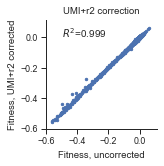

In [40]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1, figsize=(2,2))
    ax.plot(np.mean(fitness, axis=1), np.mean(fitness_UMI, axis=1), '.')
    ax.set(xlabel='Fitness, uncorrected', ylabel='Fitness, UMI+r2 corrected', xlim=-0.6, ylim=-0.6,
          title='UMI+r2 correction')
    ax.text(-0.5, 0, f"$R^{2}$={np.round(r2,3)}", fontsize=10)
    sns.despine()
#     fig.savefig(repo +'/Analysis/Plots_for_paper/umi_correction.pdf', format='pdf', bbox_inches='tight')
    fig.savefig(repo +'/Analysis/Plots_for_paper/umi_r2_correction.pdf', format='pdf', bbox_inches='tight')

    plt.show()

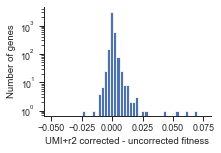

In [41]:
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1, figsize=(3,2))
    ax.hist(np.mean(fitness_UMI, axis=1) - np.mean(fitness, axis=1), bins=np.linspace(-0.05, 0.075, 50),alpha=1)
    ax.set(yscale='log', xlabel='UMI+r2 corrected - uncorrected fitness', ylabel='Number of genes')
    sns.despine()
    fig.savefig(repo+'/Analysis/Plots_for_paper/umi_correction_difference.pdf', format='pdf', bbox_inches='tight')

In [32]:
diff = np.mean(fitness, axis=1)-np.mean(fitness_UMI, axis=1)
np.where((diff>-0.1)&(diff<-0.04))[0]

array([ 219,  565, 2277, 2306])

In [35]:
len(np.where((diff>0.025)|(diff<-0.025))[0])

17